# BEE 5750 Final Project

**Name**: Akshara Chandrabalan

**ID**: ac2837

> **Due Date**
>
> Friday, 12/04/23, 9:00pm

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("CSV")
Pkg.add("DataFrames")

  Activating project at `~/Documents/BEE 5750 /lab04-akshara-c`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/BEE 5750 /lab04-akshara-c/Project.toml`
  No Changes to `~/Documents/BEE 5750 /lab04-akshara-c/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/BEE 5750 /lab04-akshara-c/Project.toml`
  No Changes to `~/Documents/BEE 5750 /lab04-akshara-c/Manifest.toml`


In [2]:
using Random 
using Distributions 
using Roots 
using Metaheuristics 
using Plots 
using CSV
using DataFrames

In [3]:
# LOADING DATA
inflows = CSV.read("inflow_yr.csv", DataFrame, delim=",") # inflow_all is obj type data frame
outflows = CSV.read("22:23outflows.csv", DataFrame, delim=",") 
temp = CSV.read("22:23temp.csv", DataFrame, delim=",") 
DO_hist = CSV.read("22:23DO.csv", DataFrame, delim=",")


Row,Date,DO
,Date,Float64
1,2022-08-09,8.0
2,2022-08-10,8.1
3,2022-08-11,8.1
4,2022-08-12,8.0
5,2022-08-13,8.1
6,2022-08-14,8.1
7,2022-08-15,8.1
8,2022-08-16,8.0
9,2022-08-17,8.1


In [4]:
# BLOCK BOOTSTRAP 
function block_bootstrap(data)
    block_size = 20
    n = nrow(data)
    num_blocks = floor(Int, n/block_size)

    bootstrap_sample = []
    
    for i=1:num_blocks
        yr = rand(2:5) 
        bootstrap_subsample = vcat(data[(i-1)*block_size+1:i*block_size, yr])
        bootstrap_sample = vcat(bootstrap_sample,bootstrap_subsample)  
    end

    return bootstrap_sample
end

test = block_bootstrap(inflows)

360-element Vector{Any}:
 162.4
 103.2
  74.3
  61.9
  56.5
  53.5
  49.8
  53.2
  51.7
  56.6
   ⋮
  65.1
  50.9
  48.3
  48.7
  43.5
  39.3
  41.5
  42.2
  39.9

In [14]:
# DO MODEL
function diss_oxy(d,K,T) # d = discharge, K = temp, T = num of time periods (1 time period = 1 day)
    DO = []
    for t = 1:T
        #DO_temp =  9.73011 - 1.59409d[t] + 0.38191d[t]^2 - 62.21589K[t] + 10.59859K[t]^2 -1.95044d[t]K[t] - 2.77400(d[t]K[t])^2
        DO_temp = 13.09 - 7.669e-5d[t] - 3.021e-1K[t]
        push!(DO, DO_temp)
    end
    return DO
end

# STORAGE FUNCTION
function storage(S1,d,T,i) # S1 = initial storage value, i = inflows
    S = []
    push!(S, S1)
    for t = 2:T
        S_temp = S[t-1] - (86400/43560)d[t] + (86400/43560)i[t]  
        push!(S, S_temp)
    end
    return S
end

test = diss_oxy(outflows[:,2], temp[:,2], 365)
test2 = storage(33900,outflows[:,2],365,inflows[:,5])


365-element Vector{Any}:
 33900
 33796.06611570247
 33681.22314049586
 33555.6694214876
 33426.54545454545
 33295.43801652892
 33164.9256198347
 33031.636363636346
 32897.95041322312
 32765.256198347088
     ⋮
  7171.338842975176
  7087.636363636333
  6908.727272727242
  6811.338842975176
  6805.388429752034
  7100.72727272724
  7156.264462809885
  7539.6694214875715
  9038.975206611538

In [133]:
# OPTIMIZED DISCHARGE
function DOdischarge_opt(d, K, T, DOref, S1, i)
    DO = diss_oxy(d, K, T)
    S = storage(S1,d,T,i) 

    obj_val = sum((DO .- DOref).^2) # to maximize d such that DO fluctuation is minimized 

    # inequality constraints
    ineq_constraints = [5-minimum(DO), maximum(S)-100000, 1000-minimum(S)]
    #=
    ineq_constraints = Array{Float64}(undef,3)
    for t in 1:T
        ineq_constraints[1] = 9 - DO[t]
        ineq_constraints[2] = S[t] - 33996
        ineq_constraints[3] = 19416 - S[t]
    end
    =#
    return obj_val, ineq_constraints, [0.0] 
end

DOdischarge_opt (generic function with 1 method)

In [143]:
# default setup
max_evals = 7000

# non-optimized parameters 
K = temp[:,2]
T = 365
DOref = 13
S1 = 29000 # ac-ft
i = inflows[:,5]

bounds = [1ones(T) 1140ones(T)]'

# calling optimizer - objective to maximize d 
results = optimize(d -> DOdischarge_opt(d, K, T, DOref, S1, i), bounds, 
    DE(options=Options(f_calls_limit=max_evals)))

Optimization Result
===================
  Iteration:       2
  Minimum:         5105.36
  Minimizer:       [395.042, 131.965, 988.07, …, 841.136]
  Function calls:  7300
  Feasibles:       0 / 3650 in final population
  Total time:      4.1426 s
  Stop reason:     Maximum objective function calls exceeded.

In [139]:
d_opt = minimizer(results)
avg = sum(d_opt)/365
avg = sum(outflows[:,2])/365

268.90849315068493

In [140]:
diff = outflows[:,2] .- d_opt



365-element Vector{Float64}:
 -116.56446028485198
 -952.6074982578261
 -337.48012476471405
 -299.54066220686
 -413.89665798243857
   19.65048972335157
 -250.261673927506
 -254.4570738272348
 -614.4429618606744
 -578.6446815640263
    ⋮
  -78.29609219612985
 -435.7696868632329
    6.1964476430401305
 -359.22049060188453
 -349.4165973432774
 -669.2389065816993
 -741.5523911944069
 -657.9857108312714
 -160.97935836486505

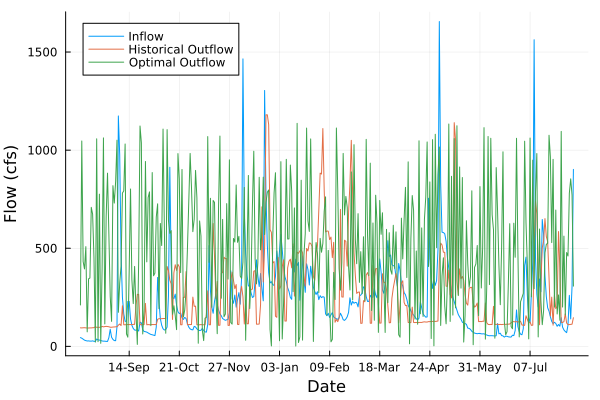

In [141]:
plot(inflows[:,1], [d_opt,outflows[:,2]])
plot(inflows[:,1], [inflows[:,5], outflows[:,2], d_opt], label=["Inflow" "Historical Outflow" "Optimal Outflow"], xlabel="Date", ylabel="Flow (cfs)")

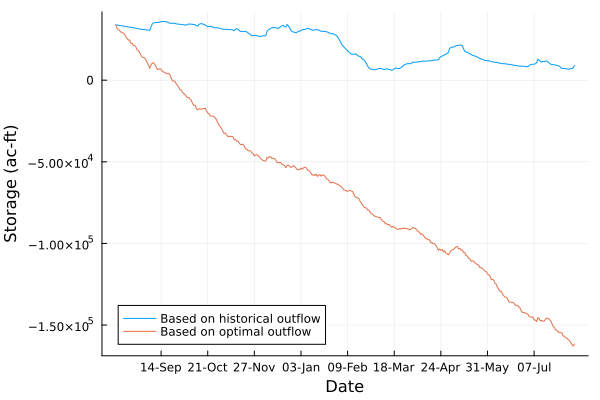

In [142]:
S_d_opt = storage(33900,d_opt,365,inflows[:,5])
plot(inflows[:,1],[test2, S_d_opt], label=["Based on historical outflow" "Based on optimal outflow"], xlabel="Date", ylabel="Storage (ac-ft)")

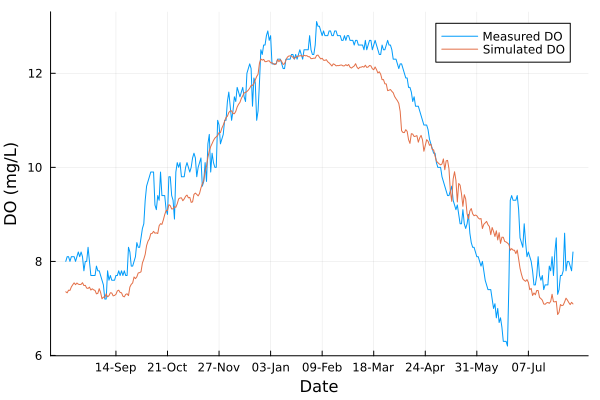

In [118]:
DO_opt = diss_oxy(d_opt, temp[:,2], 365)
plot(inflows[:,1], [DO_hist[:,2], DO_opt], label=["Measured DO" "Simulated DO"], xlabel="Date", ylabel="DO (mg/L)")

In [119]:
test = diss_oxy(d_opt, temp[:,2], 365)

365-element Vector{Any}:
 7.354094608506185
 7.331861243523416
 7.388143167441886
 7.383389384007797
 7.457436672463854
 7.503363674050278
 7.543767116074893
 7.50484078337302
 7.540223978603853
 7.515341068761269
 ⋮
 7.059355926013435
 7.070381917837292
 7.139582150738864
 7.218021141474806
 7.177365315178597
 7.124681748422774
 7.081721341825266
 7.130007469172278
 7.0954301684339685